# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.0 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.5 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-iqt56z6k
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-iqt56z6k
  Resolved https://github.com/huggingface/accelerate to commit 777334a803e7e07e00a52c08a096cc40abc00255
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=247979 sha256=fe0acd234013b4360c5f005ad05c2256a1805f40595851114dab8d02873dc36e
  Stored in directory: /tmp/pip-ephem-wheel-cache-h5288axs/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


# Load data and pre-processing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [6]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [22]:
df=pd.read_csv("/content/drive/MyDrive/yahoo_QA/train.csv",names=['class', 'title', 'content', 'answer'])


In [23]:
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'}

In [24]:
labels=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference',
        'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music',
        'Family & Relationships', 'Politics & Government']

In [25]:
df['label'] = df['class'].map(categories)

In [26]:
df = df.drop('class', axis=1)

In [27]:
label_dict = dict(zip(labels, range(0,len(labels))))
df['index']=df['label'].apply(labels.index)

In [28]:
df.groupby(['label']).size()

label
Business & Finance        140000
Computers & Internet      140000
Education & Reference     140000
Entertainment & Music     140000
Family & Relationships    140000
Health                    140000
Politics & Government     140000
Science & Mathematics     140000
Society & Culture         140000
Sports                    140000
dtype: int64

In [29]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 500)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),500)
health_idx=random.sample(list(df.query('label=="Health"').index),500)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),500)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),500)

# Use indices to select data
df= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [30]:
df

,title,content,answer,label,index
565135,Which has worse quality garbage as clothes Wal...,NaN,Damn-this is a tough question because they are...,Society & Culture,0
595790,Who ever came up with 666 as being Satan's num...,Just curious because it doesn't really make se...,"666 is the number of the antichrist, the end t...",Society & Culture,0
953882,"If you hate sin, don't you hate part of God th...",God is everywhere and everything is moving and...,"You have an interesting point, but God can do ...",Society & Culture,0
940674,What would you do in this situation?,OK first thing is first I was living with my f...,NaN,Society & Culture,0
534101,"What is the different between Catholic Church,...",NaN,"The ""Church"" is really the Born-Again believer...",Society & Culture,0
...,...,...,...,...,...
187265,Where is the best place to buy a TFT monitor c...,NaN,"Tottenham Court Road in London, or get one off...",Computers & Internet,4
1191685,Does anybody know how to get around SurfControl??,NaN,"Yea, be good and obey it. The people that inst...",Computers & Internet,4
7544,Windows 2003 server mouse goes jerky whenever ...,Mouse works fine except when the hard disk is ...,Hmmm...we run 3 servers on Win2003 (two on a r...,Computers & Internet,4
187322,I have downloaded the messenger with voice but...,I have yahoo with voice downloaded in my compu...,That happened to me too for no reason some wee...,Computers & Internet,4


In [31]:
from sklearn.utils import shuffle
df = shuffle(df)

# Model

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [34]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['title'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [36]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [37]:
import torch
torch.cuda.empty_cache()

In [38]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Train

In [39]:
train, test = train_test_split(df, test_size=0.2)
valid, test = train_test_split(test, test_size=0.5)

In [40]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [42]:
# define parameters
EPOCHS = 5

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [43]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.1257269587516785 accuracy 0.5885


  0%|          | 0/16 [00:00<?, ?it/s]

Val loss 0.8487650528550148 accuracy 0.085

Epoch 2/5
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.5223234859108925 accuracy 0.839


  0%|          | 0/16 [00:00<?, ?it/s]

Val loss 0.9544232003390789 accuracy 0.08750000000000001

Epoch 3/5
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.261699189402163 accuracy 0.924


  0%|          | 0/16 [00:00<?, ?it/s]

Val loss 1.1019781678915024 accuracy 0.088

Epoch 4/5
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.12036981462687255 accuracy 0.9725


  0%|          | 0/16 [00:00<?, ?it/s]

Val loss 1.3167362734675407 accuracy 0.091

Epoch 5/5
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.08421842200681567 accuracy 0.98


  0%|          | 0/16 [00:00<?, ?it/s]

Val loss 1.3895286228507757 accuracy 0.088



In [44]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [45]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.7252991502782631

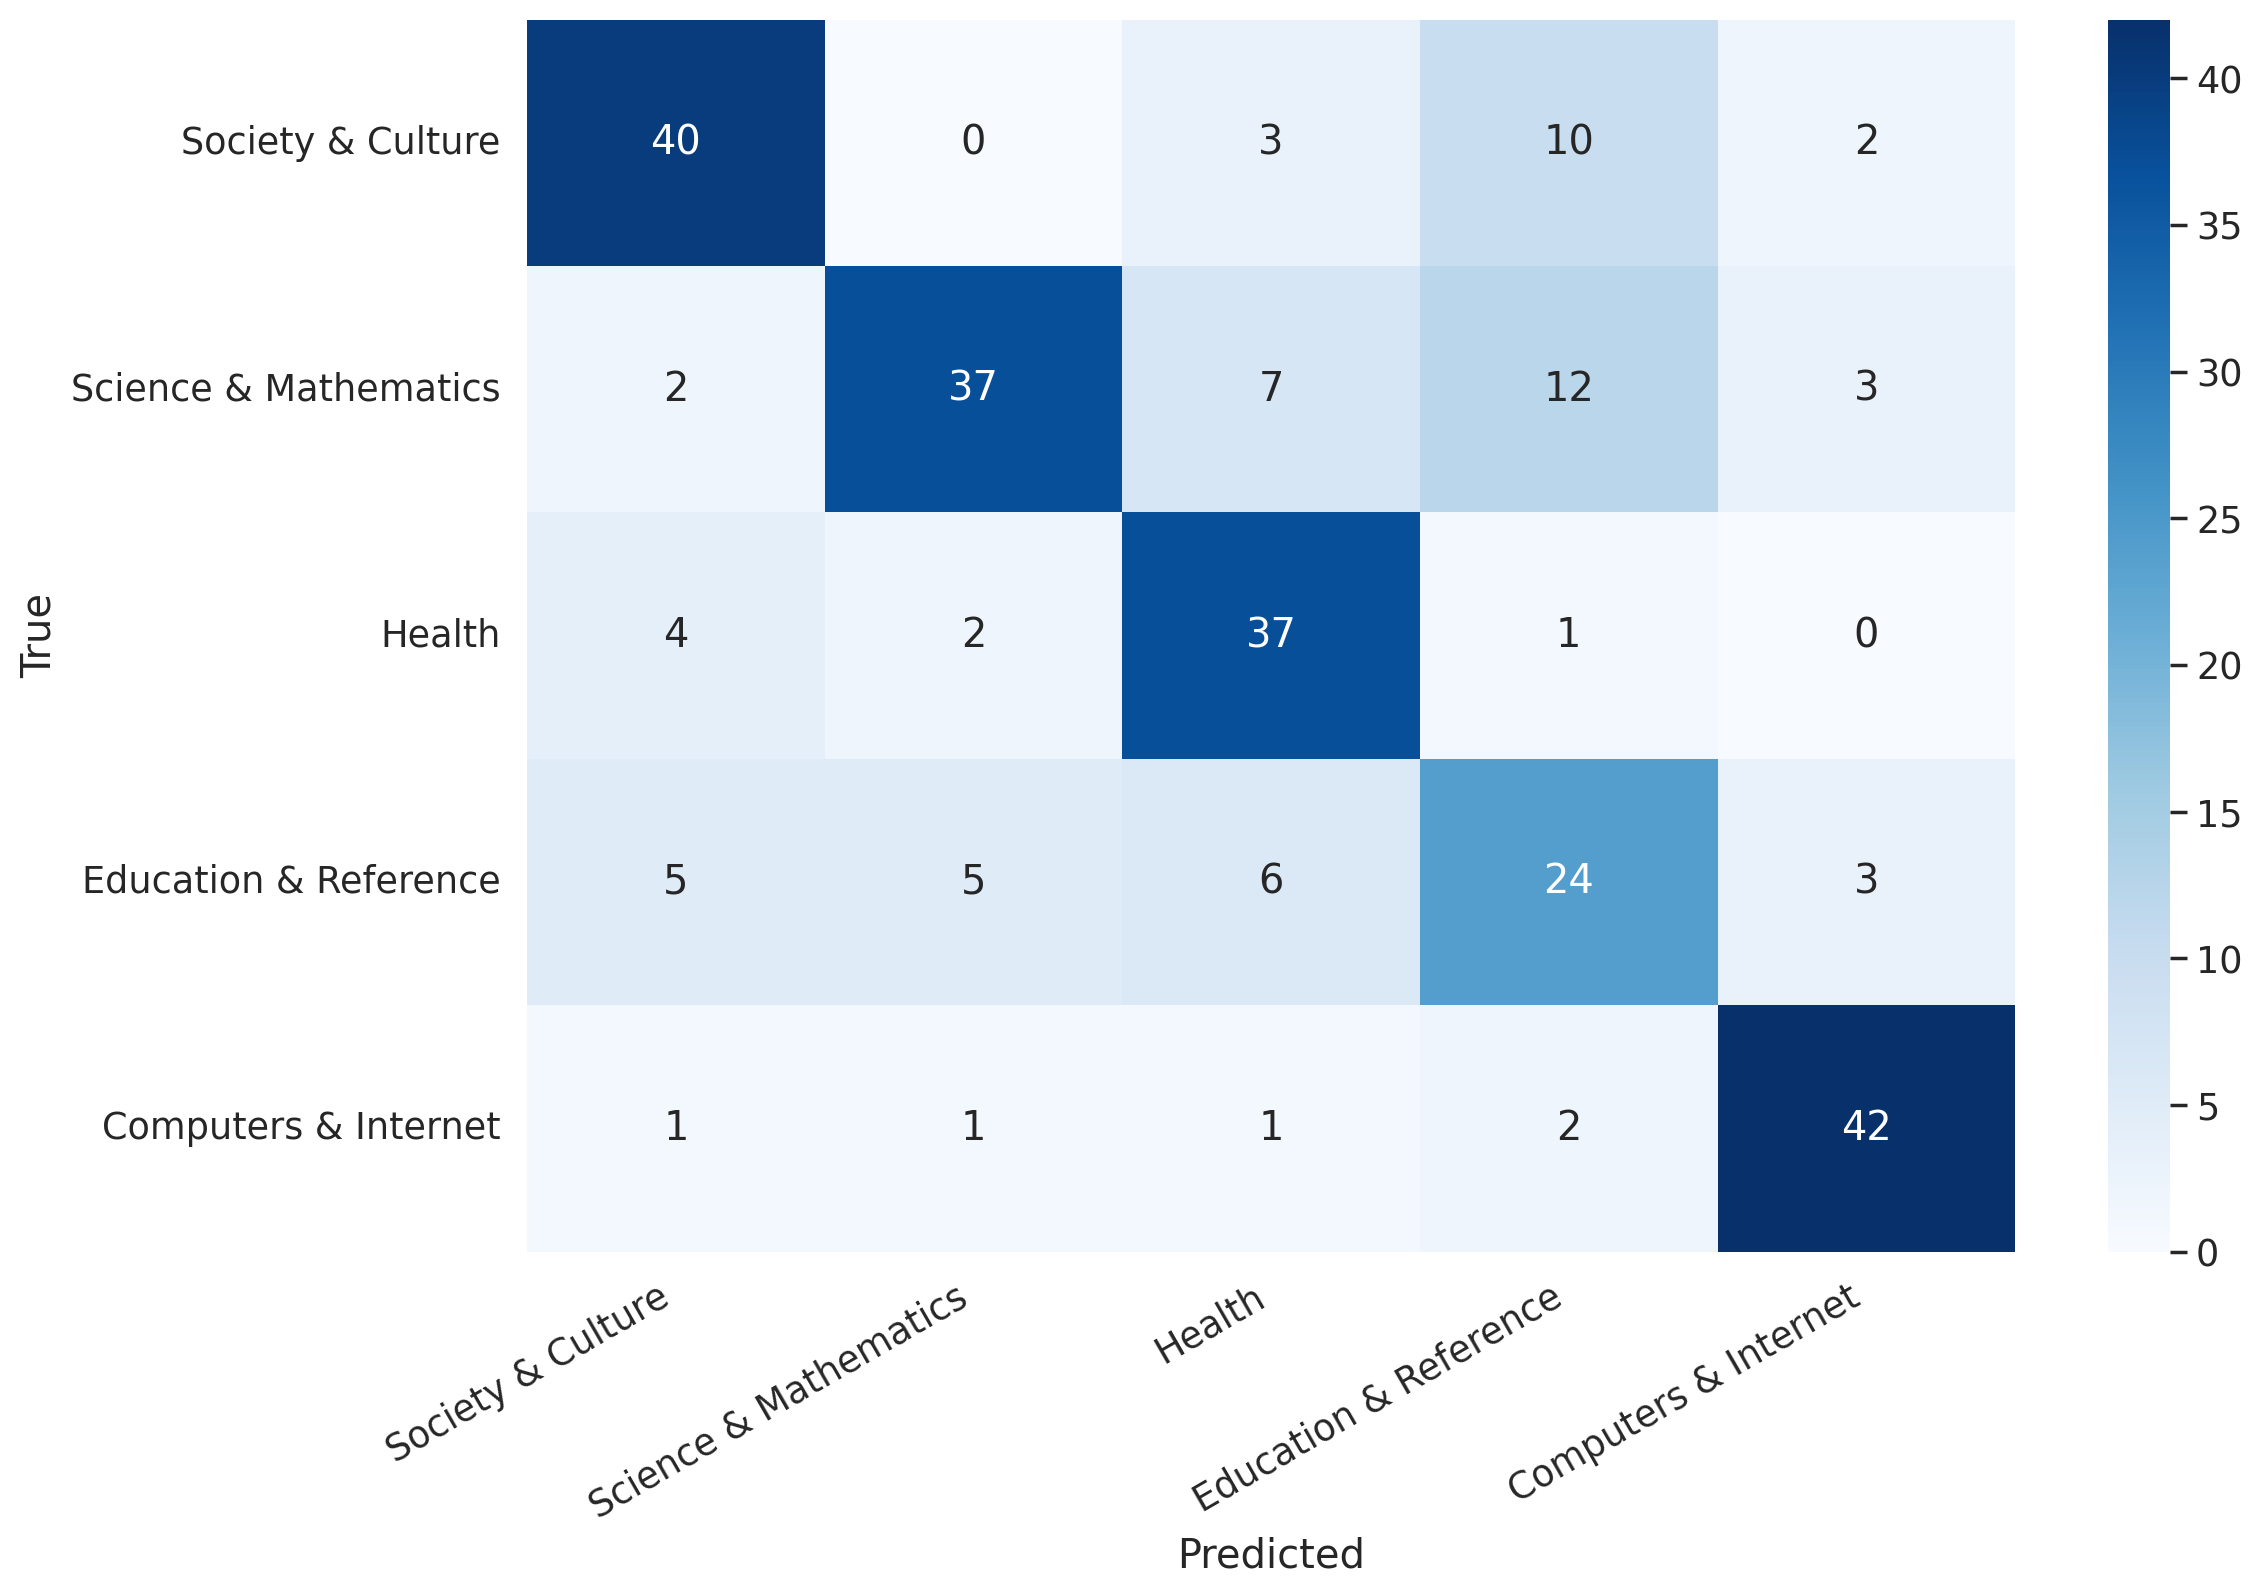

In [46]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [47]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.77      0.73      0.75        55
Science & Mathematics       0.82      0.61      0.70        61
               Health       0.69      0.84      0.76        44
Education & Reference       0.49      0.56      0.52        43
 Computers & Internet       0.84      0.89      0.87        47

             accuracy                           0.72       250
            macro avg       0.72      0.73      0.72       250
         weighted avg       0.73      0.72      0.72       250

